<a href="https://colab.research.google.com/github/krishnannarayanaswamy/ragstack-trulens-astra-demo/blob/main/Ragstack_Trulens_Astra_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📓 RagStack Trulens Astra Quickstart

In this quickstart you will create a simple LLM Chain using RAGStack and learn how to log it and get feedback on an LLM response.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)]()

# RAG

The following is an architecture for a simple chatbot over your documentation. In addition to
enabling direct user interaction, this uses a vector database to implement RAG. Whether it happens
as part of an explicit chain or as a tool available to your agent, many LLM applications should
include some form of RAG. This is the best way to provide information that is not publicly available
and/or more recent.
It consists of two major components, interacting via a vector database: the ingestion pipeline and
the simple RAG chain itself.

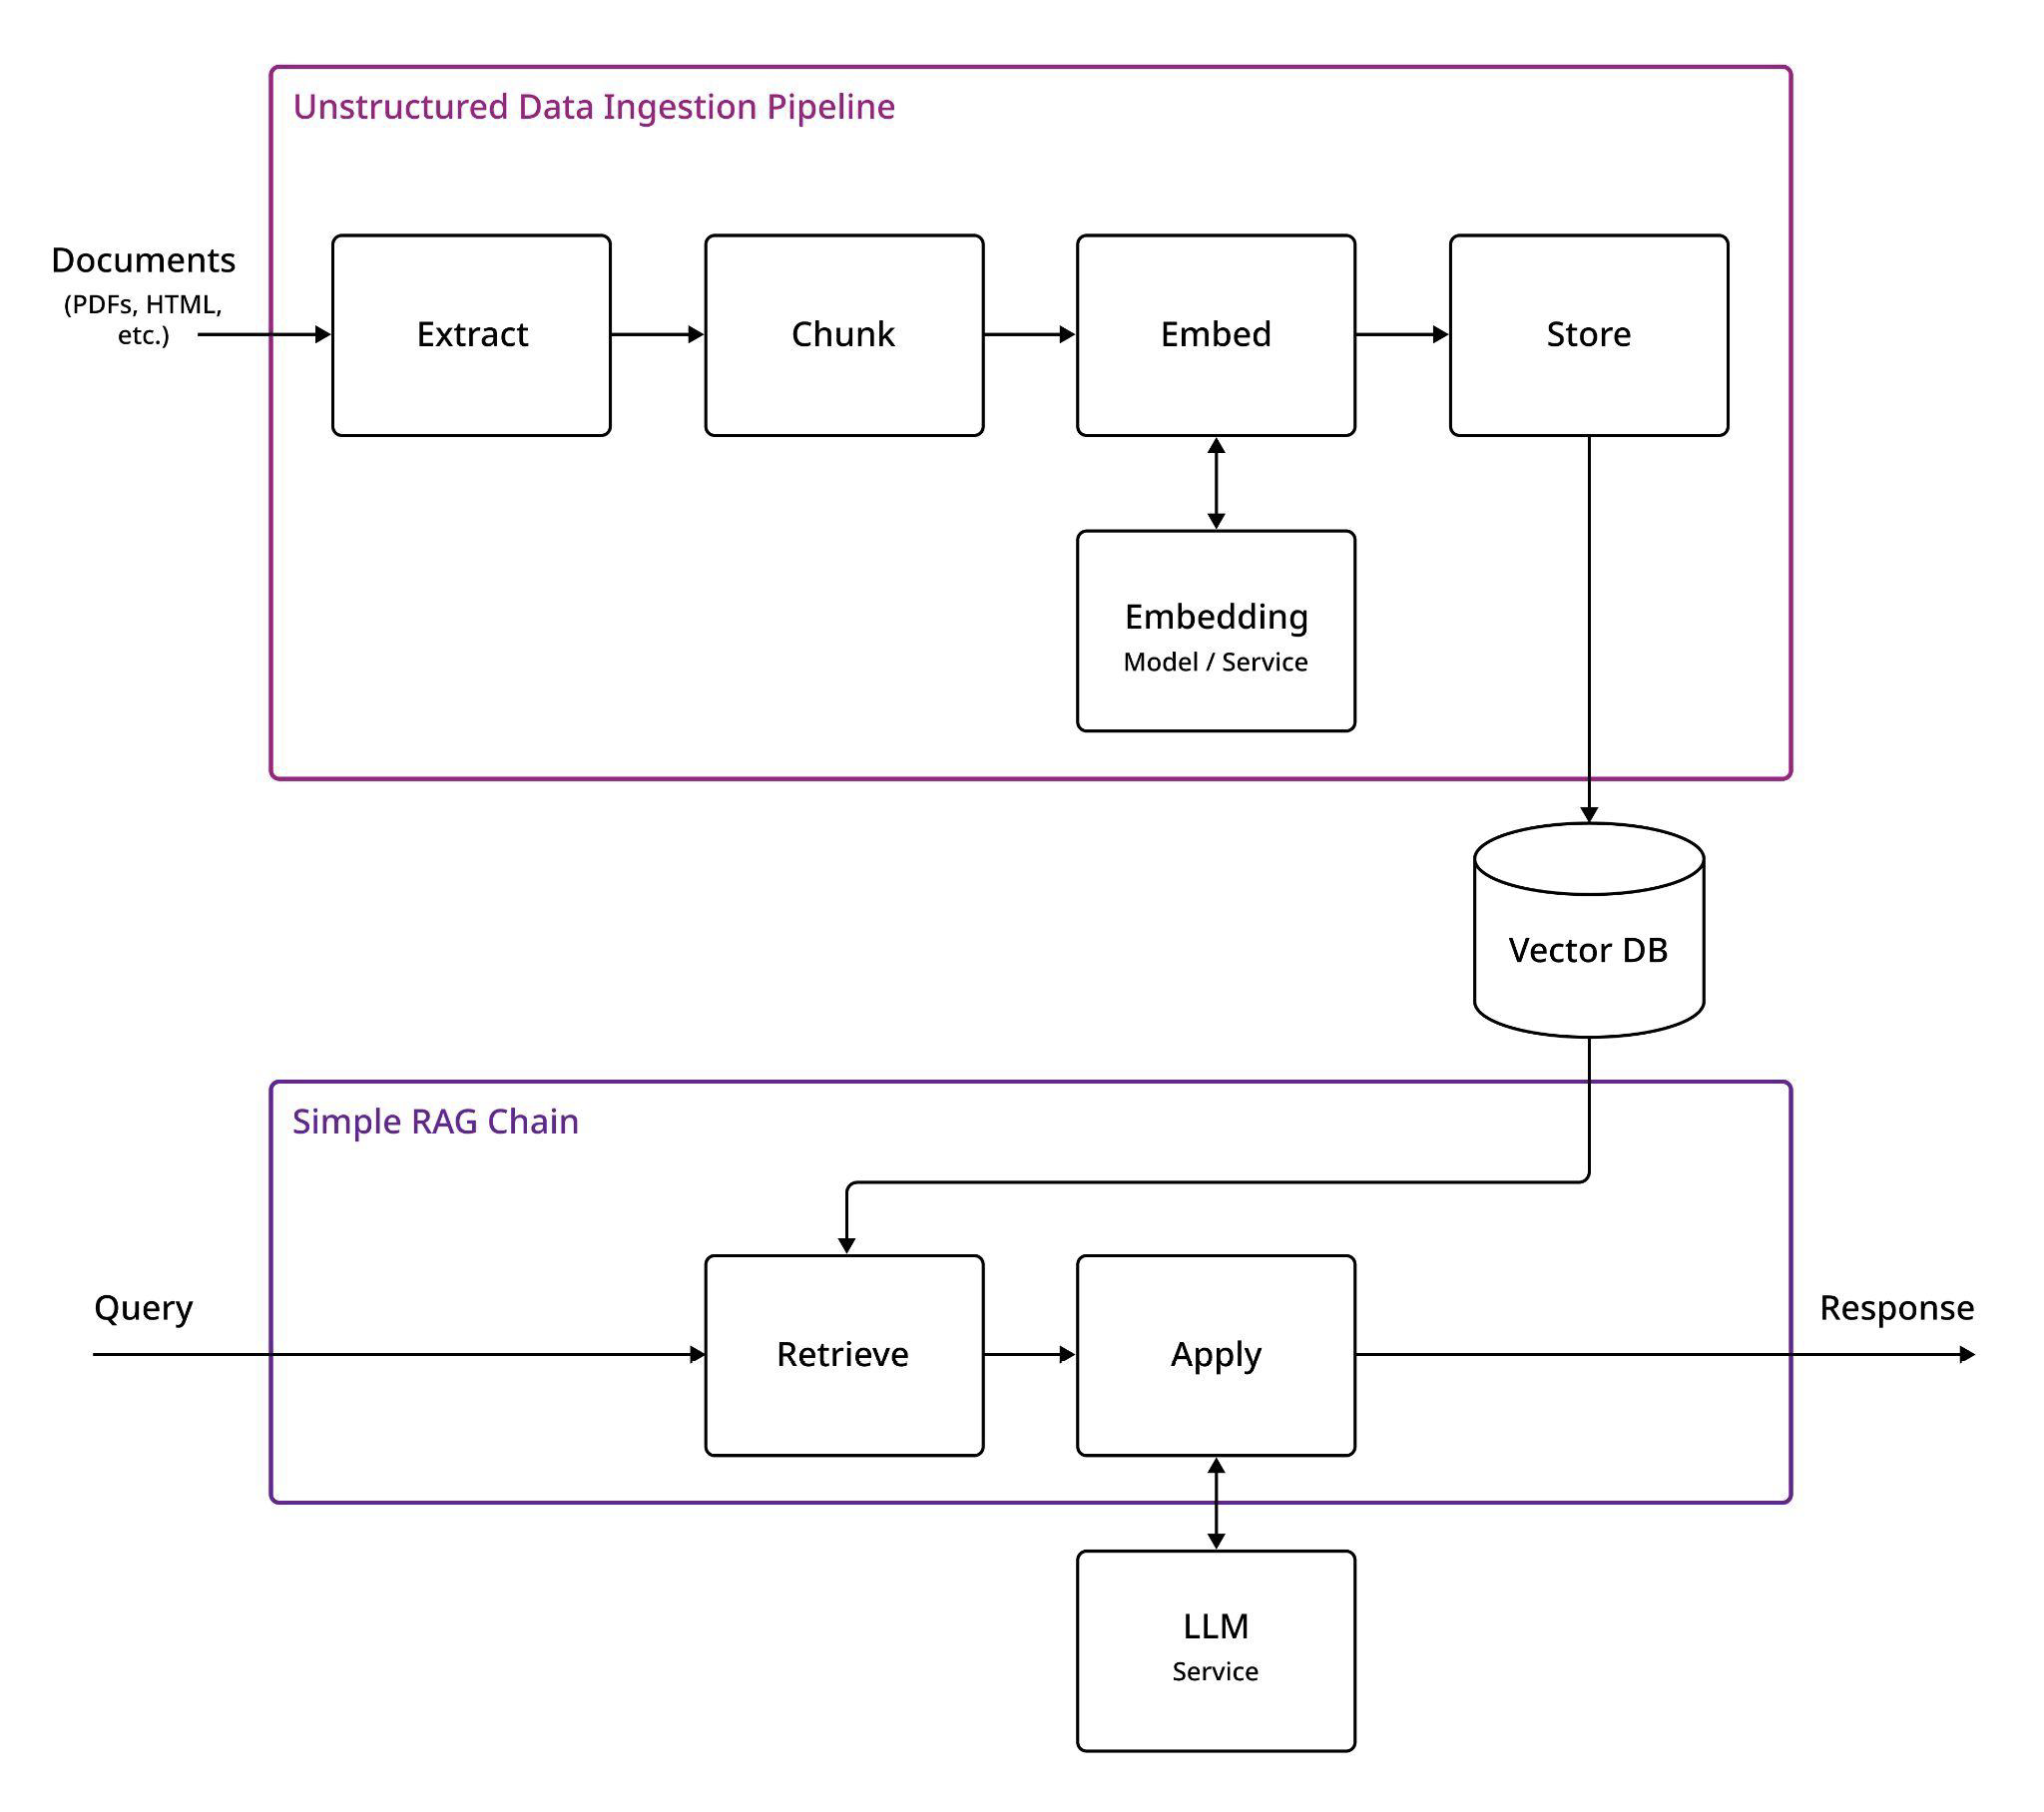




# What is DataStax RagStack?

RAGStack is a curated stack of the best open-source software for easing implementation of the RAG pattern in production-ready applications using Astra Vector DB or Apache Cassandra as a vector store.


# Why RagStack?

Gen AI apps break often
External APIs without strict guarantees
External APIs release on their own schedule

Enterprises need a proven path to success, which is NOT
Depending on unsupported open source projects

# Any Gen AI developer needs

Future-proof — as new techniques are discovered, RAGStack offers enterprise users a predictable upgrade path to always be on the cutting edge of AI.

# How?

A single command (pip install ragstack-ai) unlocks all the open-source packages required to build production-ready RAG applications with LangChain and the Astra Vector database.


# Get Started [here](https://docs.datastax.com/en/ragstack/docs/quickstart.html)


# DataStax and Langchain [Whitepaper] (https://www.datastax.com/resources/whitepaper/an-llm-agent-reference-architecture-demystifying-llm-based-systems)


# Test Suite

RAGStack tests are published to [Testspace](https://ragstack-ai.testspace.com/).

Tests are run multiple times daily against DSE and AstraDB vector databases.


## Setup
### Add API keys
For this quickstart you will need Open AI and DataStax Astra keys

In [ ]:
!pip install ragstack-ai trulens_eval datasets

In [8]:
import os
from getpass import getpass

# Enter your settings for Astra DB and OpenAI:
os.environ["ASTRA_DB_ENDPOINT"] = input("Enter you Astra DB API Endpoint: ")
os.environ["ASTRA_DB_TOKEN"] = getpass("Enter you Astra DB Token: ")
os.environ["OPENAI_API_KEY"] = getpass("Enter your OpenAI API Key: ")


Enter you Astra DB API Endpoint: https://62808754-1c66-4b58-9190-ce66a7d92b7a-us-east1.apps.astra.datastax.com
Enter you Astra DB Token: ··········
Enter your OpenAI API Key: ··········


In [12]:
from langchain_community.vectorstores import AstraDB
from langchain.embeddings import OpenAIEmbeddings
import os

# Configure your embedding model and vector store
embedding = OpenAIEmbeddings()
vstore = AstraDB(
    collection_name="ragstack_trulens",
    embedding=embedding,
    token=os.getenv("ASTRA_DB_TOKEN"),
    api_endpoint=os.getenv("ASTRA_DB_ENDPOINT"),
)
print("Astra vector store configured")

Astra vector store configured


In [13]:
from datasets import load_dataset

# Load a sample dataset
philo_dataset = load_dataset("datastax/philosopher-quotes")["train"]
print("An example entry:")
print(philo_dataset[16])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

An example entry:
{'author': 'aristotle', 'quote': 'Love well, be loved and do something of value.', 'tags': 'love;ethics'}


Constructs a set of documents from your data. Documents can be used as inputs to your vector store.

Add metadata tags to the metadata dictionary

Create a LangChain document with the quote and metadata tags

In [14]:
from langchain.schema import Document

docs = []
for entry in philo_dataset:
    metadata = {"author": entry["author"]}
    if entry["tags"]:

        for tag in entry["tags"].split(";"):
            metadata[tag] = "y"

    doc = Document(page_content=entry["quote"], metadata=metadata)
    docs.append(doc)

Create embeddings by inserting your documents into the vector store.

In [15]:
inserted_ids = vstore.add_documents(docs)
print(f"\nInserted {len(inserted_ids)} documents.")


Inserted 450 documents.


Check your collection to verify the documents are embedded.

In [17]:
print(vstore.astra_db.collection("ragstack_trulens").find())

{'data': {'documents': [{'_id': 'dd820a60cf96426ea0d63d7c04fbd649', 'content': 'The world is no nursery.', '$vector': [0.016859242917492676, -0.009847628084062612, 0.012644432653780801, -0.010259307126469728, -0.0037573895452729686, -0.006952804140364997, -0.01879348258412745, 0.024922928174016923, -0.0215118716546621, -0.001844388108159009, 0.005975883068141607, -0.0036659052618867993, 0.007279533524317905, -0.002295274783742571, 0.001996317439335177, 0.0015552324683189105, 0.026059946392920138, -0.0013518433732571764, 0.02215226210402658, -0.0010014260321335692, -0.018610513086032524, 0.021603355472386978, -0.0035776882909666105, -0.017159834733040325, -0.001957109922574054, -0.004943417451165897, 0.017382011049404435, -0.013657294395960626, 0.025720147759103307, -0.023367695822113337, -0.00024933545833585787, -0.0066489457108433085, 0.0012856807032746967, -0.045977377014764294, -0.013395910330004748, -0.004740845475258966, -0.0010635046197412347, -0.013062645855458584, 0.00588113123

### Import from LangChain and TruLens

In [18]:
# Imports main tools:
from trulens_eval import TruChain, Feedback, Tru
tru = Tru()
tru.reset_database()

# Imports from langchain to build app
from langchain.prompts import ChatPromptTemplate
from langchain.chat_models import ChatOpenAI
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough


🦑 Tru initialized with db url sqlite:///default.sqlite .
🛑 Secret keys may be written to the database. See the `database_redact_keys` option of Tru` to prevent this.


### Create RAG

In [19]:
retriever = vstore.as_retriever(search_kwargs={"k": 3})

prompt_template = """
Answer the question based only on the supplied context. If you don't know the answer, say you don't know the answer.
Context: {context}
Question: {question}
Your answer:
"""
prompt = ChatPromptTemplate.from_template(prompt_template)
model = ChatOpenAI()

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

### Send your first request

In [20]:
chain.invoke("In the given context, what subject are philosophers most concerned with?")

'Philosophers are most concerned with truth and knowledge.'

## TruLens

RAGs have become the standard architecture for providing LLMs with context in order to avoid hallucinations. However we would need a way to monitor the relevance of context that is being fed to LLMs to avoid hallucinations.

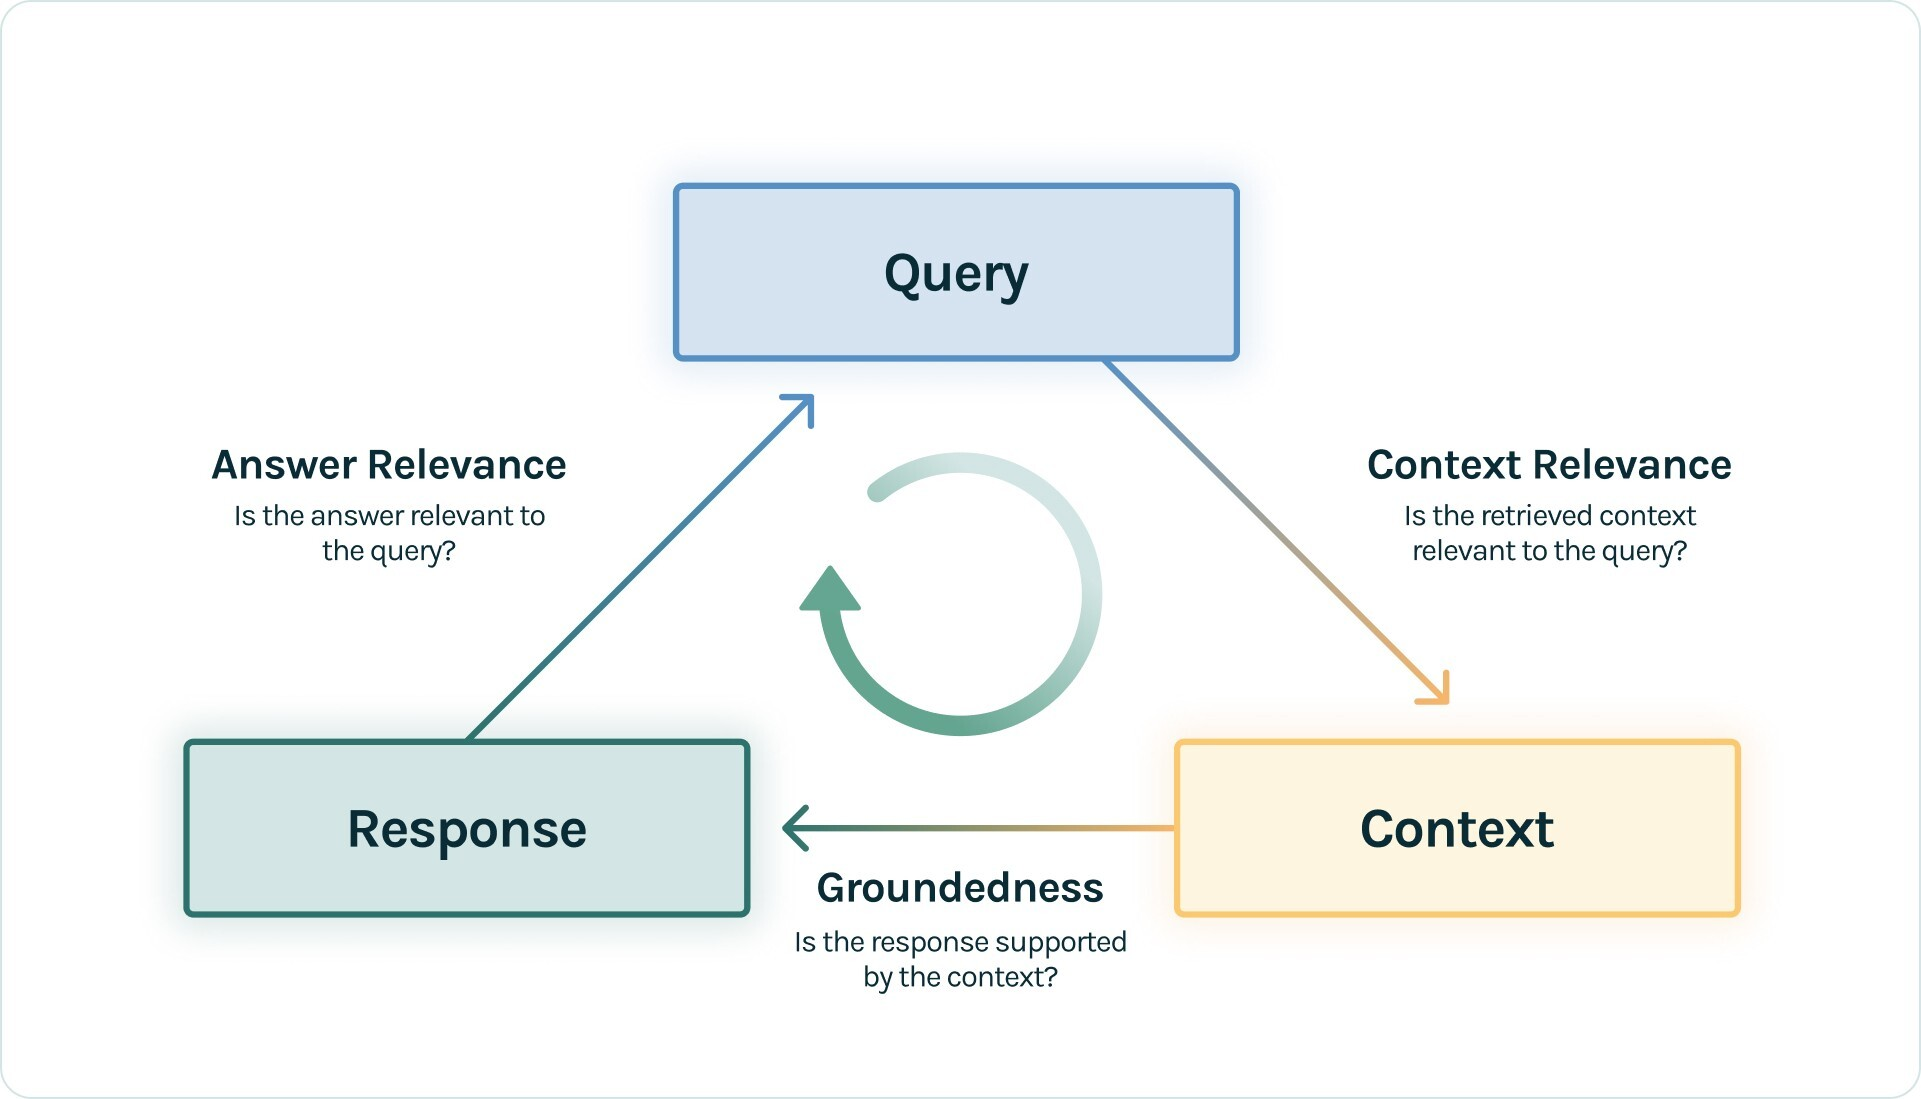

# Feedback Functions

Feedback functions, analogous to labeling functions, provide a programmatic method for generating evaluations on an application run. The TruLens implementation of feedback functions wrap a supported provider’s model, such as a relevance model or a sentiment classifier, that is repurposed to provide evaluations. Often, for the most flexibility, this model can be another LLM.

# TruLens Get Started [here](https://www.trulens.org/trulens_eval/quickstart/)

## Initialize Feedback Function(s)

In [21]:
from trulens_eval.feedback.provider import OpenAI
import numpy as np

# Initialize provider class
openai = OpenAI()

# select context to be used in feedback. the location of context is app specific.
from trulens_eval.app import App
context = App.select_context(chain)

from trulens_eval.feedback import Groundedness
grounded = Groundedness(groundedness_provider=OpenAI())
# Define a groundedness feedback function
f_groundedness = (
    Feedback(grounded.groundedness_measure_with_cot_reasons)
    .on(context.collect()) # collect context chunks into a list
    .on_output()
    .aggregate(grounded.grounded_statements_aggregator)
)

# Question/answer relevance between overall question and answer.
f_qa_relevance = Feedback(openai.relevance).on_input_output()
# Question/statement relevance between question and each context chunk.
f_context_relevance = (
    Feedback(openai.qs_relevance)
    .on_input()
    .on(context)
    .aggregate(np.mean)
)

✅ In groundedness_measure_with_cot_reasons, input source will be set to __record__.app.first.steps.context.get_relevant_documents.rets.collect() .
✅ In groundedness_measure_with_cot_reasons, input statement will be set to __record__.main_output or `Select.RecordOutput` .
✅ In relevance, input prompt will be set to __record__.main_input or `Select.RecordInput` .
✅ In relevance, input response will be set to __record__.main_output or `Select.RecordOutput` .
✅ In qs_relevance, input question will be set to __record__.main_input or `Select.RecordInput` .
✅ In qs_relevance, input statement will be set to __record__.app.first.steps.context.get_relevant_documents.rets .


## Instrument chain for logging with TruLens

In [22]:
tru_recorder = TruChain(chain,
    app_id='Chain1_ChatApplication',
    feedbacks=[f_qa_relevance, f_context_relevance, f_groundedness])

In [23]:
with tru_recorder as recording:
    llm_response = chain.invoke("In the given context, what subject are philosophers most concerned with?")

display(llm_response)

'Philosophers are most concerned with truth and knowledge in the given context.'

## Retrieve records and feedback

In [ ]:
# The record of the app invocation can be retrieved from the `recording`:

rec = recording.get() # use .get if only one record
# recs = recording.records # use .records if multiple

display(rec)

In [25]:
# The results of the feedback functions can be rertireved from
# `Record.feedback_results` or using the `wait_for_feedback_result` method. The
# results if retrieved directly are `Future` instances (see
# `concurrent.futures`). You can use `as_completed` to wait until they have
# finished evaluating or use the utility method:

for feedback, feedback_result in rec.wait_for_feedback_results().items():
    print(feedback.name, feedback_result.result)

# See more about wait_for_feedback_results:
# help(rec.wait_for_feedback_results)

relevance 1.0
qs_relevance 0.8
groundedness_measure_with_cot_reasons 0.6666666666666666


In [26]:
records, feedback = tru.get_records_and_feedback(app_ids=["Chain1_ChatApplication"])

records.head()

,app_id,app_json,type,record_id,input,output,tags,record_json,cost_json,perf_json,ts,relevance,qs_relevance,groundedness_measure_with_cot_reasons,relevance_calls,qs_relevance_calls,groundedness_measure_with_cot_reasons_calls,latency,total_tokens,total_cost
0,Chain1_ChatApplication,"{""tru_class_info"": {""name"": ""TruChain"", ""modul...",RunnableSequence(langchain_core.runnables.base),record_hash_59cd0cd654e2a7930fbe7721a6d111b2,"""In the given context, what subject are philos...","""Philosophers are most concerned with truth an...",-,"{""record_id"": ""record_hash_59cd0cd654e2a7930fb...","{""n_requests"": 2, ""n_successful_requests"": 2, ...","{""start_time"": ""2024-02-20T03:53:48.660633"", ""...",2024-02-20T03:53:50.634606,1.0,0.8,0.666667,"[{'args': {'prompt': 'In the given context, wh...","[{'args': {'question': 'In the given context, ...",[{'args': {'source': [[{'page_content': 'The p...,1,207,0.000299


In [27]:
tru.get_leaderboard(app_ids=["Chain1_ChatApplication"])

,relevance,qs_relevance,groundedness_measure_with_cot_reasons,latency,total_cost
app_id,,,,,
Chain1_ChatApplication,1.0,0.8,0.666667,1.0,0.000299


## Explore in a Dashboard

In [28]:
tru.run_dashboard() # open a local streamlit app to explore

# tru.stop_dashboard() # stop if needed

Starting dashboard ...
npx: installed 22 in 3.591s

Go to this url and submit the ip given here. your url is: https://ready-ties-create.loca.lt

  Submit this IP Address: 34.125.7.49



<Popen: returncode: None args: ['streamlit', 'run', '--server.headless=True'...>

Alternatively, you can run `trulens-eval` from a command line in the same folder to start the dashboard.

Note: Feedback functions evaluated in the deferred manner can be seen in the "Progress" page of the TruLens dashboard.